In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
import torch.nn.functional as F
from PIL import Image
root_dir = '../'
sys.path.append(root_dir)
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["figure.autolayout"] = True

# ViT-CLTT
from models.vit_contrastive import Backbone, ViTConfigExtended, ViTConfig, configuration, LitClassifier

# Setup Class: Initialize model, weights, and test directory

In [2]:
class Setup:
    def __init__(
        self,
        model_name,
        model_path,
        heads,
        patch_size,
        image_res,
        test_dir,
    ):

        self.model_name = model_name
        self.model_path = model_path
        self.heads = heads
        self.patch_size = patch_size
        self.image_res = image_res
        self.test_dir = test_dir

        # load model w/wo weights
        self.model = self.init_model(self.model_name, 
                                     self.model_path, 
                                     self.patch_size, 
                                     self.image_res, 
                                     self.heads)

        # load frames to test the model
        self.test_frames = self.get_testImages(self.test_dir) 
                                               


    def init_model(self, model, model_path, patch_size, image_res, heads):
        if model == 'vit':
            configuration = ViTConfigExtended()
            configuration.patch_size = patch_size
            configuration.image_size = image_res
            backbone = Backbone(model_type="vit", config=configuration)
            model = LitClassifier(backbone=backbone).load_from_checkpoint(model_path).backbone
            model.fc = nn.Identity()
            print("[INFO] ViT model with weights loaded")
            
        elif model == 'untrained_vit':
            configuration = ViTConfigExtended()
            configuration.num_attention_heads = configuration.num_hidden_layers = heads
            configuration.patch_size = patch_size
            configuration.image_size = image_res
            # print configuration parameters of ViT
            print("[INFO] Untrained ViT model loaded")
            print('[INFO] Image Resolution - ', configuration.image_size)
            print('[INFO] Patch Size - ', configuration.patch_size)
            print('[INFO] Hidden Layers - ', configuration.num_hidden_layers)
            print('[INFO] Heads - ', configuration.num_attention_heads)
            
            # pass the configuration parameters to get backbone
            backbone = Backbone('vit', configuration)
            model = LitClassifier(backbone).backbone
            model.fc = nn.Identity()
            
        model.eval()
        return model


    def get_testImages(self, test_dir, frame='output_0_degree.png'):
        # store test frames
        output = []

        classes = os.listdir(test_dir)
        # sort the classes 
        sorted_cls = sorted(classes)

        for cls in sorted_cls:

            output.append(os.path.join(test_dir, cls, frame))
        
        return output

# RDM Class: Process test frames, calculate RDM scores, and plot RDM

In [3]:
class RDM:
    def __init__(
        self,
        model,
        test_layer,
        test_frames,
        image_res,
        csv_path,
        filename,
    ):
        
        self.model = model
        self.test_layer = test_layer
        self.test_frames = test_frames
        self.image_res = image_res
        self.csv_path = csv_path
        self.filename = filename

        # initialize transform before processing test images
        self.transform = self.transform_img()

        # get layer-wise output
        self.intermediate_outputs = self.get_intermediate_outputs(self.model,
                                                                  self.test_frames,
                                                                  self.test_layer)

        # prepare vectors before cosine similarity
        self.all_features = self.prepare_vectors(self.intermediate_outputs)

        # generate rdm
        self.similarity_matrix = self.generate_rdm(self.all_features)

        
        
    def transform_img(self,):
        transform =  transforms.Compose([
            transforms.Resize((self.image_res, self.image_res)),
            transforms.ToTensor()
        ])
        return transform

    '''
    During the forward pass, whenever the model processes an image, 
    the registered hook captures the output of that layer.
    for example - 
    layer.register_forward_hook(hook_fn)
    
    When you register a hook, PyTorch returns a handle 
    (handle = layer.register_forward_hook(hook_fn)). 
    This handle is an object that keeps track of the registered hook.
    If you don't remove the hook, it persists in the model, and future
    forward passes will keep executing the hook, possibly 
    causing memory issues or unintended behavior.
    ''' 
    def get_intermediate_outputs(self, model, image_paths, layer_names):
        """Extracts outputs from specified layers of a frozen PyTorch model."""
        
        model.eval()
        intermediate_outputs = {name: [] for name in layer_names}
        device = next(model.parameters()).device  # Get model device
    
        
        def hook_fn(module, input, output, layer_name):
            # check and do average pooling of intermediate layers 
            if output.dim()>2: # this is an intermediate layer
                # remove the extra token i.e., the cls token - 
                output = output[:, 1:, :]
                # average mean of the patch dims -
                output = output.mean(dim=1) # you can also try max pooling here!
                
            intermediate_outputs[layer_name].append(output.detach().cpu())
    
        handles = []
        for name in layer_names:
            try:
                layer = model
                for part in name.split('.'):
                    layer = getattr(layer, part) # basically we reach the layer that we want the ouput from!
                handle = layer.register_forward_hook(lambda module, input, output, layer_name=name: hook_fn(module, input, output, layer_name))
                handles.append(handle)
            except AttributeError:
                print(f"Layer '{name}' not found in the model.")
                return {}
    
        with torch.no_grad():
            for image_path in image_paths:
                # print(image_path)
                img = Image.open(image_path)
                img_tensor = self.transform(img).unsqueeze(0).to(device)
                model(img_tensor)  # Hooks capture outputs here
    
               
    
        # Remove hooks after processing all images
        for handle in handles:
            handle.remove()
    
        return intermediate_outputs

    def prepare_vectors(self, intermediate_outputs):
        layer_name = self.test_layer[0]  # Assuming only one layer is analyzed
        all_features = np.vstack(intermediate_outputs[layer_name])  # Convert to (num_samples, feature_dim) , ex - [2000, 512] 
        all_features = torch.from_numpy(all_features).float()  # Convert numpy to tensor
        all_features = all_features - all_features.mean(dim=0) # normalize scores
        return all_features

    def generate_rdm(self, all_features):
        similarity_matrix = F.cosine_similarity(all_features.unsqueeze(1), all_features.unsqueeze(0), dim=2).cpu().numpy()
        similarity_matrix = np.round(similarity_matrix,2)
        
        if self.csv_path != "":
            # Convert the similarity matrix to a DataFrame
            df = pd.DataFrame(similarity_matrix)
            
            # Save the DataFrame to a CSV file
            df.to_csv(self.csv_path+self.filename, index=False, header=False)
            print("[INFO] CSV file saved")
            
        return similarity_matrix

    def plot_rdm(self, similarity_matrix, legend):
        # Determine the min and max values in the matrix
        min_val = np.min(similarity_matrix)
        max_val = np.max(similarity_matrix)
  
        fig, ax = plt.subplots()
        
        cmap_limits = max(abs(min_val), max_val)
        cmap = plt.cm.Greens
        
        for i in range(10):
            for j in range(10):
                c = similarity_matrix[j, i]
                color = cmap((c - min_val) / (max_val - min_val))
                ax.add_patch(plt.Rectangle((i - 0.5, j - 0.5), 1, 1, facecolor=color))
                ax.text(i, j, str(c), va='center', ha='center', color='black', fontsize=10)
        
        ax.matshow(similarity_matrix, cmap='Greens')
        plt.axis('off')

        if legend:
            # Create a color bar legend
            cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
            cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax)
            cb.set_label('Cosine Similarity')
            cb.set_ticks([])  # Remove ticks and labels
        
        plt.show()        

In [4]:
# INITIALIZATION CALL
np.random.seed(150)

obj = Setup(
        model_name="vit",
        model_path="/data/lpandey/LOGS/VIT_Time/",
        heads=6,
        patch_size=8,
        image_res=64,
        test_dir="/data/lpandey/KittenAI_Dataset/LinearProbeTrainTest/test",
)
loaded_model = obj.model
test_frames = obj.test_frames
#test_frames

[INFO] ViT model with weights loaded


In [11]:
from tqdm import tqdm

# RDM CALL TO STORE CSVs OF ALL THE LAYERS AT ONCE - 

## VIT 4H
layers = ["model.model.transformer.layers.0.1", "model.model.transformer.layers.1.1", "model.model.transformer.layers.2.1", "model.model.transformer.layers.3.1", "model.model.transformer.layers.4.1", "model.model.mlp_head"]
filename = ["layer_0.csv", "layer_1.csv", "layer_2.csv", "layer_3.csv", "layer_4.csv", "layer_mlp_head.csv"] # "layer_0.csv",


for layer_name, csv_filename in tqdm(zip(layers, filename)):
    rdm = RDM(
        model=loaded_model,
        test_layer=[layer_name], 
        test_frames=test_frames,
        image_res=64,
        csv_path="/data/lpandey/LOGS/CSV_FILES/paper_retinalWaves/publication/chick_retinalWave/OrientationSelectivity_RDMs/vit6h/160k/scrambledModels/fullTemporalShuffle/rebuttal/seed2/",
        filename=csv_filename,
)

    # print("[INFO] Embedding Shape", rdm.all_features.shape)
    similarity_matrix = rdm.similarity_matrix
    # plot rdm
    # rdm.plot_rdm(similarity_matrix, legend=False)


1it [00:02,  2.03s/it]

[INFO] CSV file saved


2it [00:03,  1.86s/it]

[INFO] CSV file saved


3it [00:04,  1.30s/it]

[INFO] CSV file saved


4it [00:05,  1.05s/it]

[INFO] CSV file saved


5it [00:05,  1.08it/s]

[INFO] CSV file saved


6it [00:07,  1.18s/it]

[INFO] CSV file saved


[INFO] CSV file saved
[INFO] Embedding Shape torch.Size([10, 512])


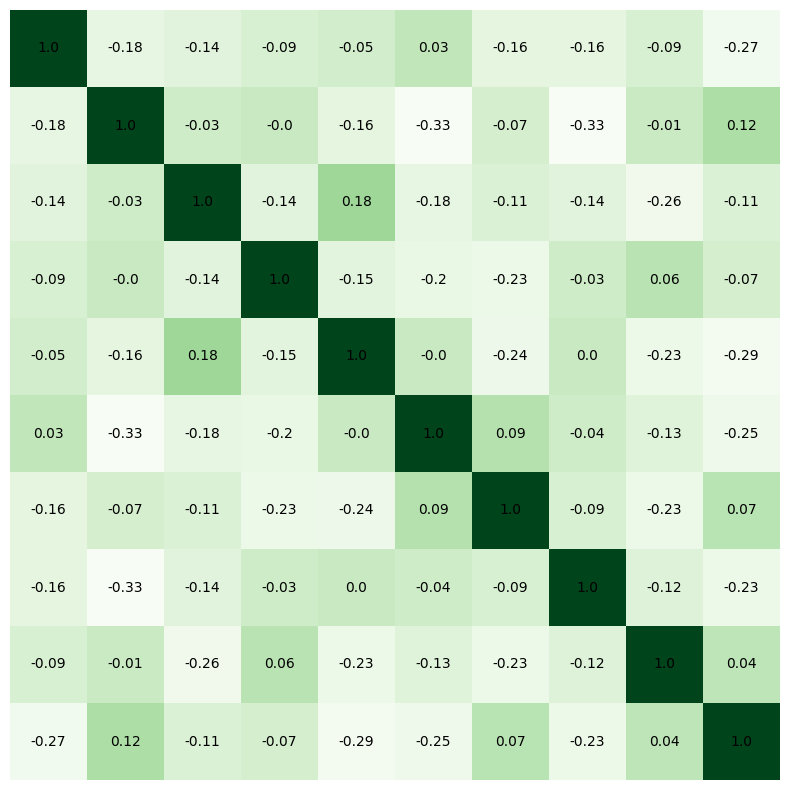

In [9]:
# # Single RDM CALL
# rdm = RDM(
#         model=loaded_model,
#         test_layer=['model.model.mlp_head'], # model.model.transformer.layers.0.1, model.model.mlp_head
#         test_frames=test_frames,
#         image_res=64,
#         csv_path="/data/lpandey/LOGS/CSV_FILES/paper_kittenAI/cognition_revision_experiments/chick_retinalWave/OrientationSelectivity_RDMs/vit3h/controlled_experiments/temporal_window1/seed0/",
#         filename="layer_mlp_head.csv",
# )

# print("[INFO] Embedding Shape", rdm.all_features.shape)
# similarity_matrix = rdm.similarity_matrix
# # plot rdm
# rdm.plot_rdm(similarity_matrix, legend=False)